# Collections Assessment Exploratory Analysis

A notebook for exploratory analysis of archival collections assessment data using Pandas.

## Set up environment

In [ ]:
# Set up environment
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
%matplotlib inline

## Load data and create DataFrame

In [28]:
# Load CSV and create DataFrame. Modify file path and header argument as needed.
file = 'data_raw/assessment_list_report.csv'
assessment = pd.read_csv(file, header=3)

Display first five rows of data to confirm DataFrame was created as expected.

In [35]:
# Display first five rows.
assessment.head()

,linked_records_record_id,linked_records_record_title,linked_records_identifier,id,accession_report,appraisal,container_list,catalog_record,control_file,deed_of_gift,...,physical_access_arrangement_rating,physical_access_arrangement_note,intellectual_access_description_rating,intellectual_access_description_note,interest_rating,interest_note,documentation_quality_rating,documentation_quality_note,research_value_rating,research_value_note
0,resource_0001,Fake Collection 1,REPO.1990.001,10,Yes,No,Yes,No,Yes,Yes,...,5,NaN,2.0,NaN,3,NaN,5,NaN,8,NaN
1,resource_0002,Fake Collection 2,REPO.1990.002,11,Yes,No,Yes,No,Yes,Yes,...,3,NaN,3.0,NaN,3,NaN,5,NaN,8,NaN
2,resource_0003,Fake Collection 3,REPO.1990.003,12,Yes,No,Yes,No,Yes,Yes,...,2,NaN,4.0,NaN,4,NaN,2,A lot of published material/reporoductions,6,NaN
3,resource_0004,Fake Collection 4,REPO.1990.004,13,Yes,No,Yes,No,Yes,Yes,...,3,NaN,5.0,NaN,1,NaN,3,NaN,4,NaN
4,resource_0005,Fake Collection 5,REPO.1990.005,14,Yes,No,Yes,No,Yes,Yes,...,3,NaN,4.0,NaN,2,NaN,5,NaN,7,NaN


Check the shape of the DataFrame to see the number of rows and columns. Each row represents an assessment record for a single resource (or accession, etc.).

In [5]:
# Check the shape of the DataFrame (rows x columns)
assessment.shape

(300, 75)

## Clean and prepare the data

### Drop empty and irrelevant columns

Several fields in the fake assessment data contain no information (i.e., are nulls).

In [46]:
# View null counts and dtypes for all columns
assessment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 75 columns):
linked_records_record_id                  300 non-null object
linked_records_record_title               300 non-null object
linked_records_identifier                 300 non-null object
id                                        300 non-null int64
accession_report                          300 non-null object
appraisal                                 300 non-null object
container_list                            300 non-null object
catalog_record                            300 non-null object
control_file                              300 non-null object
deed_of_gift                              300 non-null object
finding_aid_ead                           300 non-null object
finding_aid_online                        300 non-null object
finding_aid_paper                         300 non-null object
finding_aid_word                          300 non-null object
finding_aid_spreadsheet     

Remove all the empty columns (i.e., columns containing only NAs/missing values).

In [7]:
# Drop empty columns
assessment.dropna(how='all', inplace=True, axis=1)
assessment.shape

(300, 64)

If there other columns irrelevant to the analysis, remove those as well using a list of the columns that should be removed.

In [8]:
# Remove irrelevant columns. Modify list of columns as needed.
to_drop = ['appraisal', 
           'catalog_record', 
           'finding_aid_online', 
           'finding_aid_word', 
           'finding_aid_spreadsheet', 
           'related_eac_records', 
           'architectural_materials', 
           'art_originals', 
           'artifacts', 
           'biological_specimens', 
           'botanical_specimens', 
           'glass', 
           'technical_drawings_schematics', 
           'textiles', 
           'heat_sensitive_paper']

assessment.drop(to_drop, inplace=True, axis=1)

assessment.shape

(300, 49)

### Rename columns as needed

In this example report, the *surveyed_extent* column was used to record the size of the assessed collection in linear feet. However, there is no indication of the units of measurement in the metadata. 

In this example case, imagine you know the units because they are documented elsewhere, like a separate data collection procedures document or data dictionary. (Or perhaps in a less ideal place like an email thread or in someone's head.)

In [9]:
assessment['surveyed_extent'].head()

0     50.0
1    128.0
2    148.0
3     42.0
4    197.0
Name: surveyed_extent, dtype: float64

There's also a column with the cumbersome name *computer_storage_units*. Rename the *surveyed_extent* column to include the units of measurement (i.e. linear feet), and rename *computer_storage_units* to the easier-to-read *born_digital*.

In [10]:
# Rename surveyed_extent and computer_storage_units columns
new_names = {'surveyed_extent' : 'surveyed_extent_lf', 'computer_storage_units' : 'born_digital'}
assessment.rename(columns=new_names, inplace=True)

assessment[['surveyed_extent_lf', 'born_digital']].head()

,surveyed_extent_lf,born_digital
0,50.0,Yes
1,128.0,NaN
2,148.0,NaN
3,42.0,NaN
4,197.0,NaN


### Clean/standardize the data

Free text fields probably have variations that should be standardized.

In [11]:
# View the variations and their respective counts
assessment['purpose'].value_counts(dropna=False)

Assessment Pilot      104
Reformatting prep      81
Assessment pilot       51
assessment Pilot       41
Reformatting  prep     15
assesment pilot         5
Assessment  Pilot       2
assessment   pilot      1
Name: purpose, dtype: int64

In [12]:
# Trim whitespace and make lowercase
assessment['purpose'] = assessment['purpose'].str.strip().str.replace(r'\s+',' ').str.lower()
assessment['purpose'].value_counts(dropna=False)

assessment pilot     199
reformatting prep     96
assesment pilot        5
Name: purpose, dtype: int64

Simple spelling errors can be corrected with a simple `replace()`. (Of course, more complex spelling errors will require special attention.)

In [13]:
# Correct spelling error
assessment['purpose'] = assessment['purpose'].str.replace('assesment', 'assessment')
assessment['purpose'].value_counts(dropna=False)

assessment pilot     204
reformatting prep     96
Name: purpose, dtype: int64

### Convert ratings values to categoricals

Ratings values (e.g. 1,2,3,4,5) initially get interpreted as *int64* or *float64* dtypes, even though they are actually categories. 

In [14]:
# View dtype for physical_condition_rating
assessment['physical_condition_rating'].dtype

dtype('int64')

This will result in those columns being treated like numerical variables in descriptive statistics, as happens when using `describe()` on physical_condition_rating. That is, the statistics won't be very meaningful as they treat the ratings values (1,2,3,4,5) as numbers rather than categories.

In [15]:
# View non-meaningful descriptive stats for housing_quality_rating
assessment['physical_condition_rating'].describe()

count    300.000000
mean       2.733333
std        1.369357
min        1.000000
25%        1.750000
50%        3.000000
75%        4.000000
max        5.000000
Name: physical_condition_rating, dtype: float64

To treat them as categorical variables, convert the ratings to categorical dtypes. Since the order of the ratings is meaningful (on a scale of 1 to 5, with 1 for "very poor" and 5 for "excellent"), set the `ordered` parameter to **True**.

In [16]:
# Create list of column names for all ratings variables
ratings_names = list(assessment.columns[(assessment.columns.str.endswith('rating') == True)])

# Research value is on different scale (2-10), so treat it seperately
ratings_names.remove('research_value_rating')

# Convert the ratings (on scale of 1-5) to categorical dtypes
for name in ratings_names:
        assessment[name] = assessment[name].astype(CategoricalDtype(ordered=True))

assessment['research_value_rating'] = assessment['research_value_rating'].astype(CategoricalDtype(ordered=True))

# Reset ratings categories to int64 dtype instead of float64
for name in ratings_names:
    assessment[name] = assessment[name].cat.rename_categories([1,2,3,4,5])

assessment['research_value_rating'] = assessment['research_value_rating'].cat.rename_categories([2,3,4,5,6,7,8,9,10])

# View new dtype for physical_condition_rating
assessment['physical_condition_rating'].dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True)

It might be useful to give the categories more meaningful labels. If they are all on the same scale, rename them all with the same labels.

In [17]:
# Rename ratings categories with more meaningful labels
new_cats = {1: '1: very poor', 2: '2: poor', 3: '3: good', 4: '4: very good', 5: '5: excellent'}
for name in ratings_names:
        assessment[name] = assessment[name].cat.rename_categories(new_cats)

# View new category names for physical_condition_rating
assessment['physical_condition_rating'].dtype

CategoricalDtype(categories=['1: very poor', '2: poor', '3: good', '4: very good',
                  '5: excellent'],
                 ordered=True)

Now the summary returned by `describe()` will be more meaningful.

In [18]:
# View descriptive stats for new physical_condition_rating
assessment['physical_condition_rating'].describe()

count         300
unique          5
top       3: good
freq           78
Name: physical_condition_rating, dtype: object

## Summarize data for key variables

### How are the collection survey sizes distributed?

View a summary of extents data to see the distribution of collection survey sizes (in this case, in linear feet).

In [19]:
# View summary of surveyed_extents_lf
assessment['surveyed_extent_lf'].describe()

count    300.000000
mean     122.652500
std       96.957075
min        0.960000
25%       35.362500
50%       96.750000
75%      194.750000
max      625.000000
Name: surveyed_extent_lf, dtype: float64

Most are under 200 linear feet. But what is the outlier? To get a better sense of the distribution of the sizes, create a box plot and call out the largest collection.

Text(1.03, 575.0, 'Fake Collection 66\n(625.0 linear feet)')

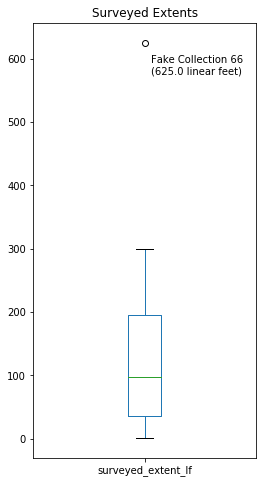

In [25]:
# Create box plot for surveyed_extents_lf
outlier = assessment.sort_values(by='surveyed_extent_lf', ascending=False).reset_index()
extent_max = assessment['surveyed_extent_lf'].max()
title_max = outlier.loc[0, 'linked_records_record_title']
annotation = f'{title_max}\n({extent_max} linear feet)'
assessment['surveyed_extent_lf'].plot.box(title='Surveyed Extents', figsize=(4, 8)).annotate(annotation, (1.03, extent_max-50))

### How much material needs to be reformatted?

Let's say you want more information to help plan some reformatting projects, such as how much stuff you need to reformat.

In [21]:
# Total surveyed_extent_lf for reformatting_prep
reformat_extent = assessment.groupby('purpose').get_group('reformatting prep')['surveyed_extent_lf'].sum()
print(f'{reformat_extent} linear feet of material was assessed for reformatting.')

11128.48 linear feet of material was assessed for reformatting.


### What kind of condition are these collections in?

Since it is more expensive and time-consuming to reformat materials that are fragile or in poor physical condition, it would also be good to know the condition of the collections to be reformatted.

In [22]:
# Create pivot table-like view of physical_condition_rating, in cubic feet
reformat = assessment.groupby('purpose').get_group('reformatting prep')

reformat_table = pd.pivot_table(reformat, values='surveyed_extent_lf', index='purpose', 
               columns='physical_condition_rating', aggfunc='sum', 
               fill_value='not used', dropna=False)

reformat_table

physical_condition_rating,1: very poor,2: poor,3: good,4: very good,5: excellent
purpose,,,,,
reformatting prep,2179.86,2986.62,2416.0,1555.0,1991.0


And it will be easier to get a sense of the distribution with a simple chart. In this case, the volume of material in **poor condition** stands out (nearly 3,000 linear feet!), which may be a valuable insight if you are planning a reformatting project and need to budget for things like conservation treatment and special digitization services.

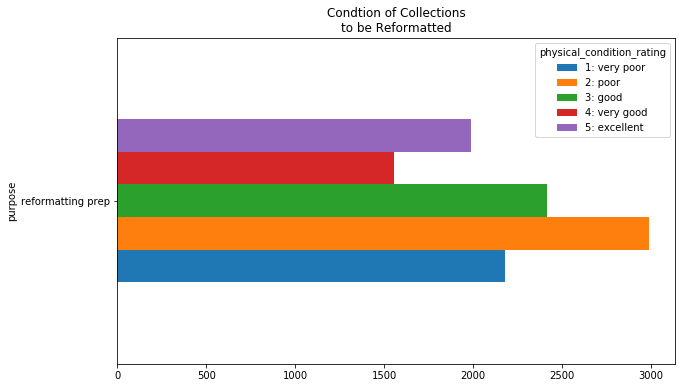

In [23]:
reformat_table.plot.barh(title='Condtion of Collections\nto be Reformatted', figsize=(10, 6))

### What are the major at-risk formats in the surveyed collections?

These pivot table-like views can be especially useful for counting totals for multiple physical formats. Calculate the totals for some potentially unstable or at-risk formats...

In [25]:
# Create pivot table-like views of counts for multiple formats
formats = ['audio_materials',
           'born_digital', 
           'photographs', 
           'scrapbooks', 
           'video_materials']

formats_table = pd.pivot_table(assessment, values=formats, index='purpose', 
                               aggfunc='count', margins=True, dropna=False)

formats_table = formats_table.assign(All=formats_table.apply(np.sum, axis = 1).astype('int'))

formats_table

,audio_materials,born_digital,photographs,scrapbooks,video_materials,All
purpose,,,,,,
assessment pilot,87,36,27,2,17,169
reformatting prep,48,27,10,12,10,107
All,135,63,37,14,27,276


...and plot counts for these formats. In this case, the volume of audio materials stands out. This can be valuable information, as much archival sound recordings are on magnetic media, and [a lot can go wrong](https://www.clir.org/pubs/reports/pub54/2what_wrong/) 
with magnetic media. (Keep in mind these are counts of collections, **not** counts of individual recordings. See the note on limitations to the counts data below.)

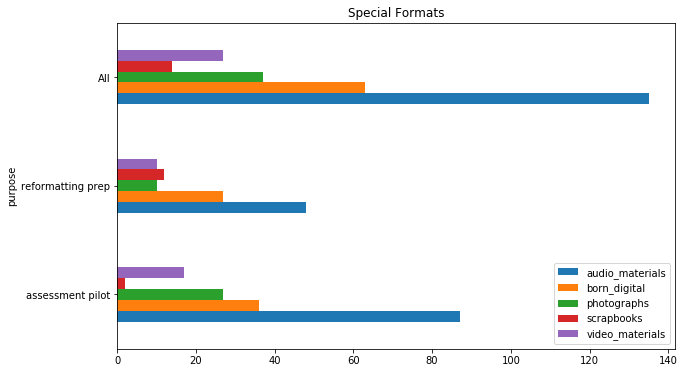

In [26]:
# Plot counts for multiple physical formats
formats_table[formats].plot.barh(title='Special Formats', figsize=(10, 6))

## Filtering data

### Which collections contain specific formats?

Select the rows for all collections that have materials from a "special format" list, and which were assessed for the purpose of preparing for reformatting. 

In [27]:
# Create DataFrame of subset of records for special formats
formats_records = assessment[(assessment['audio_materials'] == 'Yes') | 
                             (assessment['born_digital'] == 'Yes') |
                             (assessment['photographs'] == 'Yes') | 
                             (assessment['scrapbooks'] == 'Yes') |
                             (assessment['video_materials'] == 'Yes')]

base_cols = ['linked_records_record_id', 'linked_records_record_title', 'surveyed_extent_lf'] + ratings_names

formats_records.groupby('purpose').get_group('reformatting prep')[base_cols].head()

,linked_records_record_id,linked_records_record_title,surveyed_extent_lf,housing_quality_rating,physical_condition_rating,physical_access_arrangement_rating,intellectual_access_description_rating,interest_rating,documentation_quality_rating
6,resource_0007,Fake Collection 7,169.0,3: good,1: very poor,5: excellent,1: very poor,1: very poor,1: very poor
7,resource_0008,Fake Collection 8,113.0,1: very poor,5: excellent,1: very poor,3: good,1: very poor,5: excellent
8,resource_0009,Fake Collection 9,252.0,1: very poor,4: very good,1: very poor,4: very good,3: good,1: very poor
9,resource_0010,Fake Collection 10,68.0,3: good,3: good,4: very good,5: excellent,5: excellent,5: excellent
27,resource_0028,Fake Collection 28,189.0,1: very poor,5: excellent,4: very good,4: very good,5: excellent,4: very good


## Note: Limitations to the counts data

Note that the total rows selected above is less than the total count in formats_table:

In [28]:
formats_records.groupby('purpose').get_group('reformatting prep').shape

(70, 49)

In [29]:
formats_table.groupby('purpose').get_group('reformatting prep')

,audio_materials,born_digital,photographs,scrapbooks,video_materials,All
purpose,,,,,,
reformatting prep,48,27,10,12,10,107


This is because some assessment records have multiple types of "special formats," which is not surprising given the diveresity of formats found in archives. However, it does point to a limitation of the (example) assessment data: **the formats variables capture the presence (or absence) of a given format, but not the quantity of individual objects in those formats**.

This shortcoming *could* be addressed during data collection by including an estimation (or count) of the number of items in a note field. Of course, that would result in mulitple values (for multiple formats) being held in a free-text note field, which introduces another set of challenges (consitent data entry, parsing the multi-values fields, etc.) Choose your battles wisely. 

## Writing to file

You should probably share this information with others, say, in an Excel file. Write formats_records and formats_table to Excel, with `pd.ExcelWriter`.

In [32]:
# Write assessment records and table to different sheets of an Excel file. Modify file path and header argument as needed.
with pd.ExcelWriter('data/collections_for_reformatting.xlsx') as writer:
    formats_records.groupby('purpose').get_group('reformatting prep').to_excel(writer, sheet_name='records', index=False)
    formats_table.groupby('purpose').get_group('reformatting prep').to_excel(writer, sheet_name='counts')

## Forging ahead
The same general approach used here can be adapted to clean and explore - and dig deeper into - all manner of collections (meta)data (catalog records, digital asset metadata, etc.). As stated at the beginning, this notebook only scratches the surface of how Pandas can be used in scalable, reproducable solutions that advance data-informed decision-making and produce new knowledge from collections (meta)data.  